# Understanding the internal structure of `meer21cm`

The best way to understand the inner workings of a package is always to read the source code. However, in some cases, it is easier to start with some logging to see what part of the source code gets triggered by your calculation. This is of course also very useful for debug purposes. We provide a few examples below.

In [1]:
from meer21cm import PowerSpectrum, MockSimulation
import numpy as np
import matplotlib.pyplot as plt
from meer21cm.plot import plot_map

# turn on info level logging
import logging
logging.basicConfig(level=logging.INFO)

/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [2]:
ps = PowerSpectrum(
    band='L',
    survey='meerklass_2021',
)
ps.get_enclosing_box()

INFO:meer21cm.dataanalysis:found meerklass_2021_L in predefined settings, using default settings and override the following parameters: nu, nu_min, nu_max, num_pix_x, num_pix_y, wproj
INFO:meer21cm.power:get_enclosing_box: setting self.box_len, self.box_origin, self.box_ndim
INFO:meer21cm.power:get_enclosing_box: setting the model self.kmode and self.mumode to correspond to the field k-modes


You can see that, setting `band='L'` and `survey='meerklass_2021'` trigger the initialisation to automatically set predefined frequency and map dimensions parameters, which determines the survey lightcone.
Then, invoking `get_enclosing_box` triggers the calculation to find the dimensions of the rectangular box that encloses the defined survey lightcone.

Let's see another example of invoking the model power spectrum for the first tracer (usually assumed to be HI):

In [3]:
ps.auto_power_tracer_1_model;

INFO:meer21cm.cosmology:get_matter_power_spectrum_camb: setting self._matter_power_spectrum_fnc
INFO:meer21cm.power:get_model_power_i: setting self._auto_power_tracer_1_model
INFO:meer21cm.power:multiplying _auto_power_tracer_1_model with mean_amp_1**2: 1.0**2 to get auto_power_tracer_1_model


You can see that, in order to get `ps.auto_power_tracer_1_model`, it internally invokes `get_matter_power_spectrum_camb` to calculate the linear matter power spectrum first. Then `get_model_power_i` is used to set `ps._auto_power_tracer_1_model`, which is then multiplied by `ps.mean_amp_1**2` to get the `ps.auto_power_tracer_1_model`.

In [3]:
ps.auto_power_tracer_2_model;
ps.tracer_bias_2 is None

INFO:meer21cm.power:tracer_bias_2 is None, returning None


True

You can see that, since `ps.tracer_bias_2` is `None` by default, invoking `ps.auto_power_tracer_2_model` returns `None`. You can set a bias and recalculate:

In [4]:
ps.tracer_bias_2 = 1.5
ps.auto_power_tracer_2_model;

INFO:meer21cm.cosmology:get_matter_power_spectrum_camb: setting self._matter_power_spectrum_fnc
INFO:meer21cm.power:get_model_power_i: setting self._auto_power_tracer_2_model
INFO:meer21cm.power:multiplying _auto_power_tracer_2_model with mean_amp_2**2: 1.0**2 to get auto_power_tracer_2_model


On the other hand, if you want to add temperature unit to the power spectra, you can do:

In [5]:
ps.omega_hi = 5e-4
ps.mean_amp_1 = "average_hi_temp"

In [6]:
ps.auto_power_tracer_1_model;

INFO:meer21cm.power:get_model_power_i: setting self._auto_power_tracer_1_model
INFO:meer21cm.power:getting mean_amp_1 from self.average_hi_temp
INFO:meer21cm.power:multiplying _auto_power_tracer_1_model with mean_amp_1**2: 0.00010282763474838113**2 to get auto_power_tracer_1_model


You can see that the code internally invokes the calculation of the mean brightness temperature and multiplies it to the power spectrum.

Note that, in this case, since the power spectrum calculation has been invoked before and stored within the `_auto_power_tracer_1_model` attribute, the calculation is not repeated, as you can see from the log information.

Now let us look at a case of generating mock observation:

In [2]:
mock = MockSimulation(
    survey='meerklass_2021',
    band='L',
    num_discrete_source=1000000,
    mean_amp_1='average_hi_temp',
    tracer_bias_1=1.5,
    tracer_bias_2=1.5,
    omega_hi=5e-4,
)

INFO:meer21cm.dataanalysis:found meerklass_2021_L in predefined settings, using default settings and override the following parameters: nu, nu_min, nu_max, num_pix_x, num_pix_y, wproj


In [3]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1);

INFO:meer21cm.power:get_enclosing_box: setting self.box_len, self.box_origin, self.box_ndim
INFO:meer21cm.power:get_enclosing_box: setting the model self.kmode and self.mumode to correspond to the field k-modes
INFO:meer21cm.cosmology:get_matter_power_spectrum_camb: setting self._matter_power_spectrum_fnc
INFO:meer21cm.power:get_model_power_noobs_i: setting self._auto_power_tracer_1_model_noobs
INFO:meer21cm.mock:invoking get_mock_field_from_power assuming lognormal distribution
INFO:meer21cm.mock:get_mock_tracer_field: setting _mock_tracer_field_1


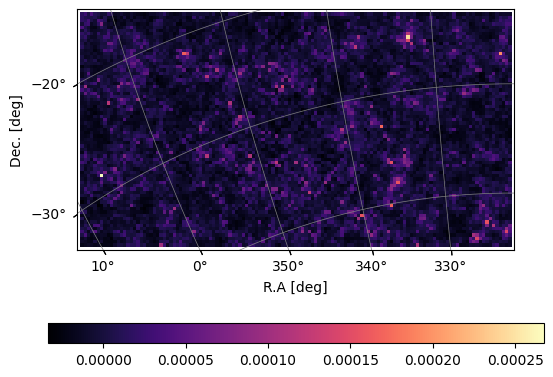

In [4]:
plot_map(mock.data, mock.wproj, W=mock.W_HI)

In [4]:
mock.propagate_mock_tracer_to_gal_cat()

INFO:meer21cm.power:get_model_power_noobs_i: setting self._auto_power_tracer_2_model_noobs
INFO:meer21cm.mock:invoking get_mock_field_from_power assuming lognormal distribution
INFO:meer21cm.mock:get_mock_tracer_field: setting _mock_tracer_field_2
INFO:meer21cm.mock:get_mock_tracer_position_in_box: setting _mock_tracer_position_in_box
INFO:meer21cm.mock:invoking get_mock_tracer_position_in_radecz with flat_sky=False: setting _mock_tracer_position_in_radecz
INFO:meer21cm.mock:propagate_mock_tracer_to_gal_cat: setting ra_gal, dec_gal, z_gal with trim=True


You can see that, by generating the discrete mock tracers and propagate them into souce catalogues, first the input power spectrum `_auto_power_tracer_2_model_noobs` is calculated. The mock tracer field is then generated and stored in `_mock_tracer_field_2`, which is then used to generate `_mock_tracer_position_in_box`. The source positions in the rectangular box are then used to generate their positions in (RA,Dec,z) and stored in `_mock_tracer_position_in_radecz`. Finally, they are passed to the `ra_gal`, `dec_gal` and `z_gal`, after trimming out sources outside the survey lightcone.

If you want more detailed logging information, you can turn up the level of logging output to DEBUG by `logging.basicConfig(level=logging.DEBUG)`. Note that however the output will be excessive.